# Overview
This is a simple end to end example of how you can use SAS Viya for analysis
The example follows these steps:
1. Importing the needed R packages
1. Starting a CAS session on an already running CAS server
1. Load the needed CAS Action Sets
1. Loading data from the local file system to the CAS server
1. Explore the data
1. Impute missing values
1. Partition the data into training and validation partitions
1. Build a decision tree
1. Build a neural network
1. Build a decision forest
1. Build a gradient boost
1. Assess the models
1. Build ROC charts

# Set Up the R Notebook for Analysis


## Documentation Links:
* [SAS® Viya™ 3.5: System Programming Guide](https://go.documentation.sas.com/?docsetId=caspg&docsetTarget=titlepage.htm&docsetVersion=3.5&locale=en)
* [Getting Started with SAS® Viya™ 3.5 for R](https://go.documentation.sas.com/?docsetId=caspg3r&docsetTarget=titlepage.htm&docsetVersion=3.5&locale=en)

Load the needed packages to complete analysis

In [7]:
# Load necessary packages
library('swat')
library('ggplot2')
library('reshape2')
library('dplyr')
options(cas.print.messages = FALSE)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Connect to CAS

* Documentation to [Connect and Start a Session](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg3r&docsetTarget=p0paczu3x2qu0wn1p94ees7y5ls8.htm&locale=en)

This is the simpliest way to connect to CAS for more details see the [documentation] 

In [8]:
Sys.setenv(CAS_CLIENT_SSL_CA_LIST = "/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem")
conn <- CAS('controller', 5570)

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...
NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).


# Load Actionsets

* Documentation for [How to Run Actions](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg3r&docsetTarget=p11zy53gvlofvsn1glguw9vuuhru.htm&locale=en)

In [9]:
actionsets <- c('sampling', 'fedsql', 'decisionTree', 'neuralNet', 'percentile')
for(i in actionsets){
    loadActionSet(conn, i)
}

# Load data from CSV
For this trial you cannot add files to the system

In [10]:
castbl <- cas.read.csv(conn, 'http://support.sas.com/documentation/onlinedoc/viya/exampledatasets/hmeq.csv')

# Explore the data

In [11]:
head(castbl)

BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


In [12]:
summary(castbl)

Selecting by Frequency


      BAD              LOAN          MORTDUE           VALUE       
 Min.   :0.0000   Min.   : 1100   Min.   :  2063   Min.   :  8000  
 1st Qu.:0.0000   1st Qu.:11100   1st Qu.: 46268   1st Qu.: 66069  
 Median :0.0000   Median :16300   Median : 65019   Median : 89236  
 Mean   :0.1995   Mean   :18608   Mean   : 73761   Mean   :101776  
 3rd Qu.:0.0000   3rd Qu.:23300   3rd Qu.: 91491   3rd Qu.:119832  
 Max.   :1.0000   Max.   :89900   Max.   :399550   Max.   :855909  
                                  NA's   :   518   NA's   :   112  
     REASON          JOB            YOJ              DEROG         
 DebtCon:3928   Other  :2388   Min.   :  0.000   Min.   :  0.0000  
 HomeImp:1780   ProfExe:1276   1st Qu.:  3.000   1st Qu.:  0.0000  
 NA's   : 252   Office : 948   Median :  7.000   Median :  0.0000  
                Mgr    : 767   Mean   :  8.922   Mean   :  0.2546  
                Self   : 193   3rd Qu.: 13.000   3rd Qu.:  0.0000  
                NA's   : 279   Max.   : 41.000  

## Visualize Numeric Variables

Warning message:
“Removed 4740 rows containing non-finite values (stat_bin).”

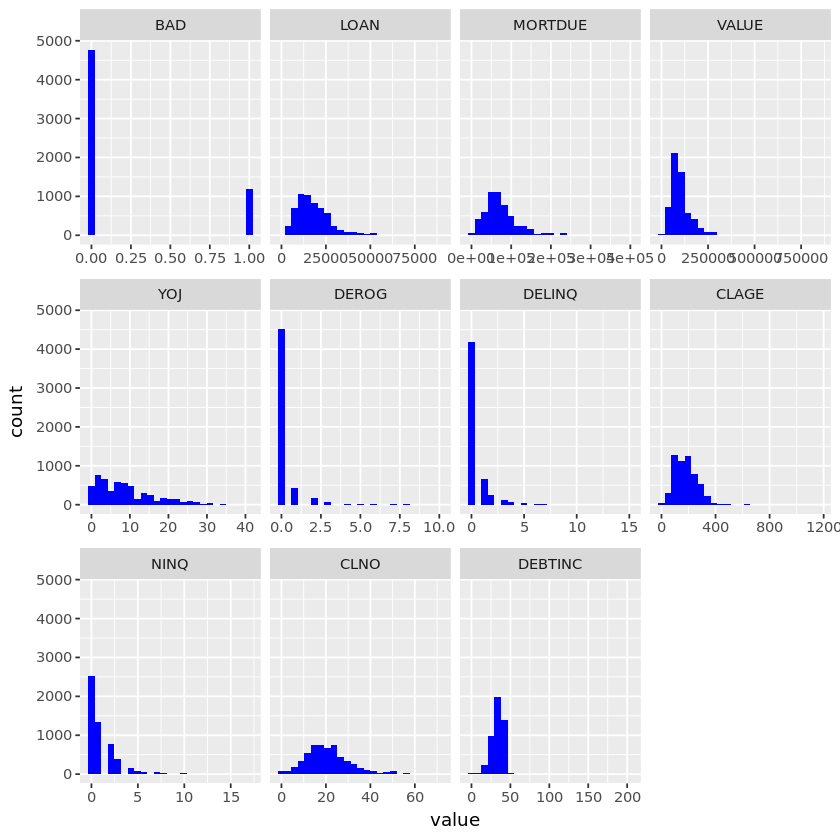

In [13]:
# Bring data locally
df <- to.casDataFrame(castbl, obs = nrow(castbl))
# Use reshape2's melt to help with data formatting
d <- melt(df[sapply(df, is.numeric)], id.vars=NULL)
ggplot(d, aes(x = value)) +
    facet_wrap(~variable,scales = 'free_x') +
    geom_histogram(fill = 'blue', bins = 25)

## Count Missing Values

In [14]:
# Get the number of missing values for all variables
tbl <- cas.simple.distinct(castbl)$Distinct[,c('Column', 'NMiss')]
tbl


Column,NMiss
BAD,0
LOAN,0
MORTDUE,518
VALUE,112
REASON,252
JOB,279
YOJ,515
DEROG,708
DELINQ,580
CLAGE,308


In [15]:
# Easy way to get missing values for numeric variables
cas.nmiss(castbl)

BAD    LOAN MORTDUE   VALUE     YOJ   DEROG  DELINQ   CLAGE    NINQ    CLNO 
      0       0     518     112     515     708     580     308     510     222 
DEBTINC 
   1267

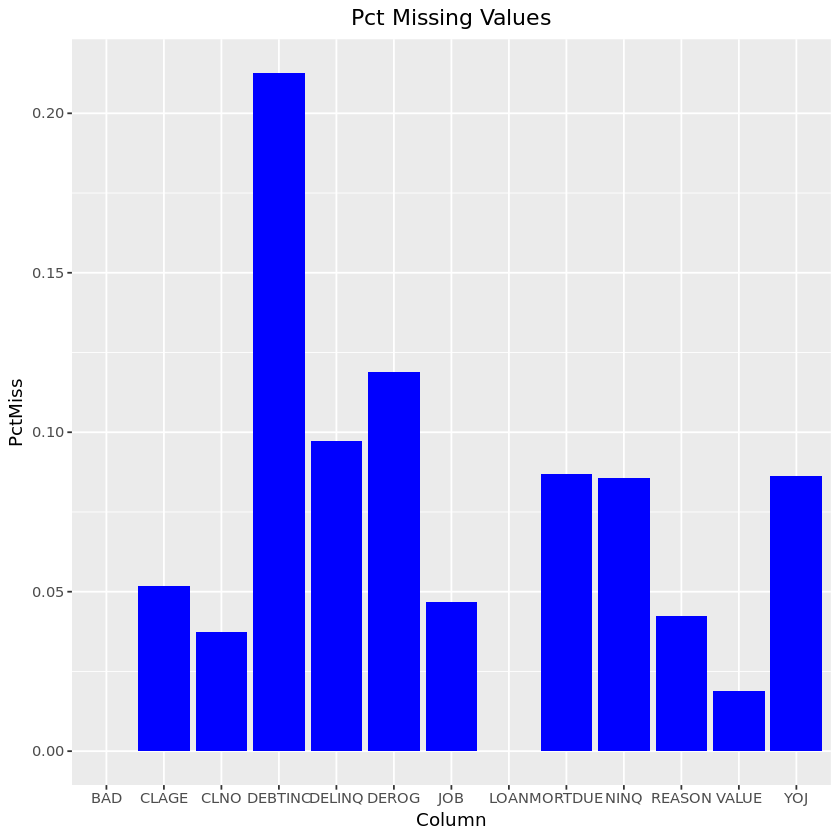

In [16]:
# Visualize the missing data
tbl$PctMiss <- tbl$NMiss/nrow(castbl)
ggplot(tbl, aes(Column, PctMiss)) +
    geom_col(fill = 'blue') +
    ggtitle('Pct Missing Values') +
    theme(plot.title = element_text(hjust = 0.5))

# Impute Missing Values

In [17]:
# Impute missing values
cas.dataPreprocess.impute(castbl,
    methodContinuous = 'MEDIAN',
    methodNominal = 'MODE',
    inputs = colnames(castbl)[-1],
    copyAllVars = TRUE,
    casOut = list(name = 'hmeq', 
                replace = TRUE)
)

Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
LOAN,Median,IMP_LOAN,5960,0,16300.00000,
MORTDUE,Median,IMP_MORTDUE,5442,518,65019.00000,
VALUE,Median,IMP_VALUE,5848,112,89235.50000,
REASON,Mode,IMP_REASON,5708,252,NaN,DebtCon
JOB,Mode,IMP_JOB,5681,279,NaN,Other
YOJ,Median,IMP_YOJ,5445,515,7.00000,
DEROG,Median,IMP_DEROG,5252,708,0.00000,
DELINQ,Median,IMP_DELINQ,5380,580,0.00000,
CLAGE,Median,IMP_CLAGE,5652,308,173.46667,
NINQ,Median,IMP_NINQ,5450,510,1.00000,


# Partition the data into Training and Validation

In [18]:
# Partition the data
cas.sampling.srs(conn,
    table = 'hmeq',
    samppct = 30,
    partind = TRUE,
    output = list(casOut = list(name = 'hmeq', replace = T), copyVars = 'ALL')
)

$SRSFreq
  NObs NSamp
1 5960  1788

$OutputCasTables
                  casLib Name Label Rows Columns
1 CASUSERHDFS(sebastien) hmeq       5960      26

# Variable Mapping
Define varibles with generic labels and reuse between model calls

In [19]:
#Note: I do not want to hard code any of my variable names.
indata <- 'hmeq'

# Get variable info and types
colinfo <- head(cas.table.columnInfo(conn, table = indata)$ColumnInfo, -1)

# My target variable is the first column
target <- colinfo$Column[1]

# For models that can inherently handle missing values (ex: Decision Tree)
inputs <- colinfo$Column[-1]
nominals <- c(target, subset(colinfo, Type == 'varchar')$Column)

# For models that cannot handle missing values (ex: Neural Network)
imp.inputs <- grep('IMP_', inputs, value = T)
imp.nominals <- c(target, grep('IMP_', nominals, value = T))

# Build Models

## Decision Tree

In [20]:
cas.decisionTree.dtreeTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = inputs,
    nominals = nominals,
    varImp = TRUE,
    casOut = list(name = 'dt_model', replace = TRUE)
)

Descr,Value
Number of Tree Nodes,33.00000
Max Number of Branches,2.00000
Number of Levels,6.00000
Number of Leaves,17.00000
Number of Bins,50.00000
Minimum Size of Leaves,5.00000
Maximum Size of Leaves,3106.00000
Number of Variables,24.00000
Confidence Level for Pruning,0.25000
Number of Observations Used,4172.00000


## Forest

In [21]:
# Train the forest model
cas.decisionTree.forestTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = inputs,
    nominals = nominals,
    casOut = list(name = 'rf_model', replace = TRUE)
)

Descr,Value
Number of Trees,50.00000
Number of Selected Variables (M),5.00000
Random Number Seed,0.00000
Bootstrap Percentage (%),63.21206
Number of Bins,50.00000
Number of Variables,24.00000
Confidence Level for Pruning,0.25000
Max Number of Tree Nodes,39.00000
Min Number of Tree Nodes,19.00000
Max Number of Branches,2.00000


## Gradient Boosting

In [22]:
cas.decisionTree.gbtreeTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = inputs,
    nominals = nominals,
    casOut = list(name = 'gbt_model', replace = TRUE)
)

Descr,Value
Number of Trees,50.00
Distribution,2.00
Learning Rate,0.10
Subsampling Rate,0.50
Number of Selected Variables (M),24.00
Number of Bins,50.00
Number of Variables,24.00
Max Number of Tree Nodes,31.00
Min Number of Tree Nodes,15.00
Max Number of Branches,2.00


## Neural Network

In [23]:
cas.neuralNet.annTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = imp.inputs,
    hidden = 7,
    nominals = imp.nominals,
    casOut = list(name = 'nn_model', replace = TRUE)
)

Progress,Objective,Loss,FitError
1,2.794649,2.794649,0.4458293
2,1.996029,1.996029,0.2001438
3,1.856819,1.856819,0.1982263
4,1.644581,1.644581,0.1713806
5,1.589595,1.589595,0.1646692
6,1.569046,1.569046,0.1625120
7,1.557040,1.557040,0.1601151
8,1.535277,1.535277,0.1574784
9,1.506865,1.506865,0.1550815
10,1.499063,1.499063,0.1543624


# Score the Models

In [24]:
models <- c('dt','rf','gbt','nn')
scores <- c(cas.decisionTree.dtreeScore, cas.decisionTree.forestScore, 
            cas.decisionTree.gbtreeScore, cas.neuralNet.annScore)
names(scores) <- models

# Function to help automate prediction process on new data
score.params <- function(model){return(list(
    object       = defCasTable(conn, indata),
    modelTable   = list(name = paste0(model, '_model')),
    copyVars     = list(target, '_PartInd_'),
    assessonerow = TRUE,
    casOut       = list(name = paste0(model, '_scored'), replace = T)
))}
lapply(models, function(x) {do.call(scores[[x]], score.params(x))})

[[1]]
[[1]]$OutputCasTables
                  casLib      Name Rows Columns
1 CASUSERHDFS(sebastien) dt_scored 5960      16

[[1]]$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                     12.852348993


[[2]]
[[2]]$OutputCasTables
                  casLib      Name Rows Columns
1 CASUSERHDFS(sebastien) rf_scored 5960       9

[[2]]$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                     13.506711409


[[3]]
[[3]]$OutputCasTables
                  casLib       Name Rows Columns
1 CASUSERHDFS(sebastien) gbt_scored 5960       8

[[3]]$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                     8.0704697987

[[3]]$ErrorMetricInfo
   TreeID Trees NLeaves        MCR   LogLoss        ASE      RASE     MAXAE
1       0     1      16 0.19949664 0.4603837 0.14623147 0.3824022 0.8140545
2       1     2      29 0.19949664 0.4301968 0.13504254 0.3674813 0.8284328
3       2     3      39 0.19949664 0.4062008 0.12574545 0.3546061 0.8404973
4       3     4      55 0.19949664 0.3860805 0.11800282 0.3435154 0.8542575
5       4     5      69 0.19580537 0.3692548 0.11139258 0.3337553 0.8645895
6       5     6      85 0.15906040 0.3550958 0.10599238 0.3255647 0.8745527
7       6     7     101 0.14614094 0.3426573 0.10130336 0.3182819 0.8837443
8       7     8     116 0.13657718 0.3318259 0.09743704 0.3121491 0.8922849
9       8     9     131 0.12701342 0.3227283 0.09414100 0.3068240 0.9000633
10      9    10     147 0.12013423 0.3144798 0.09119440 0.3019841 0.9069685
11     10    11     161 0.11526846 0.3076276 0.08879509 0.2979851 0.9139652
12     11    12     176 0.11023490 0.3016428 0.08666851 0.2943952 0.9185238
13     12    13     191 0.10654362 0.2964216 0.08504690 0.2916280 0.9252202
14     13    14     207 0.10352349 0.2908837 0.08326264 0.2885527 0.9299765
15     14    15     222 0.10151007 0.2864346 0.08188736 0.2861597 0.9341551
16     15    16     237 0.10218121 0.2826904 0.08082260 0.2842932 0.9379097
17     16    17     252 0.10083893 0.2786869 0.07964230 0.2822097 0.9429536
18     17    18     268 0.09949664 0.2750531 0.07862108 0.2803945 0.9462319
19     18    19     283 0.09798658 0.2717276 0.07763713 0.2786344 0.9494399
20     19    20     299 0.09765101 0.2680388 0.07656290 0.2767000 0.9535297
21     20    21     314 0.09714765 0.2649041 0.07566117 0.2750658 0.9563635
22     21    22     327 0.09681208 0.2621596 0.07493945 0.2737507 0.9582940
23     22    23     343 0.09731544 0.2586739 0.07388276 0.2718138 0.9611379
24     23    24     358 0.09513423 0.2560823 0.07306659 0.2703083 0.9636616
25     24    25     372 0.09345638 0.2532257 0.07215893 0.2686241 0.9655026
26     25    26     386 0.09278523 0.2508334 0.07145644 0.2673134 0.9669232
27     26    27     400 0.09228188 0.2481299 0.07065425 0.2658087 0.9684207
28     27    28     416 0.09211409 0.2460884 0.07012237 0.2648063 0.9700428
29     28    29     432 0.09144295 0.2434052 0.06930925 0.2632665 0.9699020
30     29    30     442 0.08926174 0.2417387 0.06883718 0.2623684 0.9711486
31     30    31     458 0.08859060 0.2391678 0.06803790 0.2608408 0.9722691
32     31    32     474 0.08808725 0.2379837 0.06783613 0.2604537 0.9748077
33     32    33     488 0.08791946 0.2362999 0.06730621 0.2594344 0.9751518
34     33    34     504 0.08842282 0.2349315 0.06701392 0.2588705 0.9758202
35     34    35     513 0.08741611 0.2335314 0.06653903 0.2579516 0.9763886
36     35    36     528 0.08590604 0.2316202 0.06594437 

# Assess Models

## Confusion Matrix

In [25]:
# Load the percentile actionset for scoring
loadActionSet(conn, 'percentile')

# Useful function for model assessment
assess.model <- function(model){
    cas.percentile.assess(conn,
        table    = list(name = paste0(model,'_scored'), 
                        where = '_PartInd_ = 1'),
        inputs   = paste0('_', model, '_P_           1'),
        response = target,
        event    = '1')
}

model.names <- c('Decision Tree', 'Random Forest', 
                 'Gradient Boosting', 'Neural Network')
roc.df <- data.frame()
for (i in 1:length(models)){
    tmp <- (assess.model(models[i]))$ROCInfo
    tmp$Model <- model.names[i] 
    roc.df <- rbind(roc.df, tmp)
}

# Manipulate the dataframe
compare <- subset(roc.df, round(roc.df$CutOff, 2) == 0.5)
rownames(compare) <- NULL
compare[,c('Model','TP','FP','FN','TN')]

Model,TP,FP,FN,TN
Decision Tree,268,145,86,1289
Random Forest,115,7,239,1427
Gradient Boosting,246,50,108,1384
Neural Network,102,23,252,1411


## Misclassification

In [26]:
# Build a dataframe to compare the misclassification rates
compare$Misclassification <- 1 - compare$ACC
miss <- compare[order(compare$Misclassification), c('Model','Misclassification')]
rownames(miss) <- NULL
miss

Model,Misclassification
Gradient Boosting,0.08836689
Decision Tree,0.12919463
Random Forest,0.13758389
Neural Network,0.15380313


## ROC

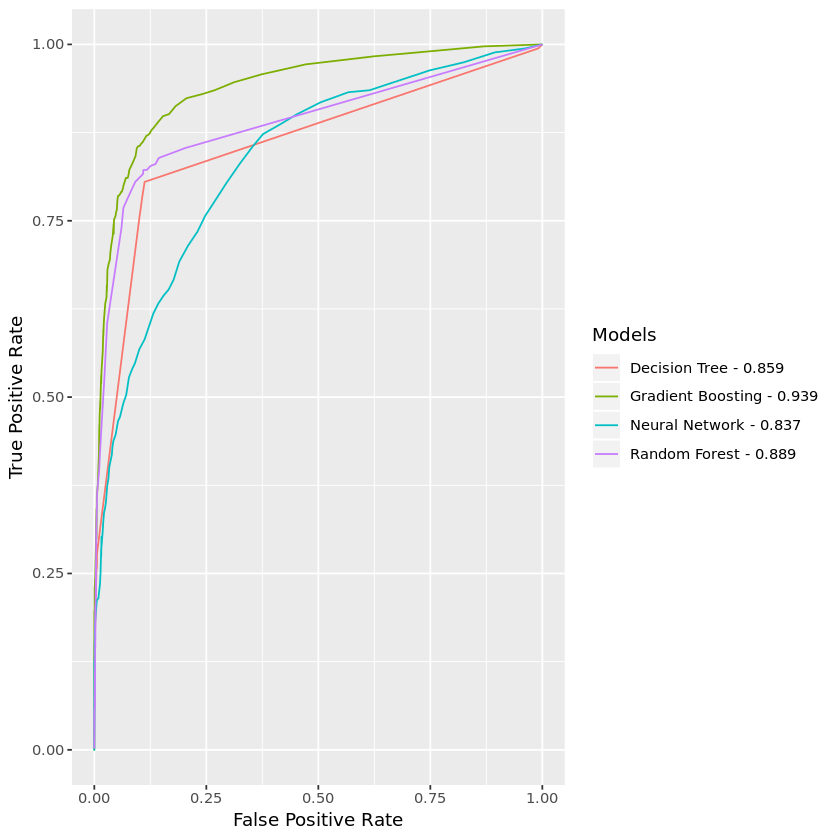

In [27]:
# Add a new column to be used as the ROC curve label
roc.df$Models <- paste(roc.df$Model, round(roc.df$C, 3), sep = ' - ')

# Create the ROC curve
ggplot(data = roc.df[c('FPR', 'Sensitivity', 'Models')],
    aes(x = as.numeric(FPR), y = as.numeric(Sensitivity), colour = Models)) +
    geom_line() +
    labs(x = 'False Positive Rate', y = 'True Positive Rate')

## End the session

In [28]:
# End the session
cas.session.endSession(conn)

list()